<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#folder-list,-image-list" data-toc-modified-id="folder-list,-image-list-1">folder list, image list</a></span></li><li><span><a href="#label-dictionary" data-toc-modified-id="label-dictionary-2">label dictionary</a></span></li><li><span><a href="#make-tfrecord" data-toc-modified-id="make-tfrecord-3">make tfrecord</a></span></li><li><span><a href="#decode-check" data-toc-modified-id="decode-check-4">decode check</a></span></li></ul></div>

# folder list, image list

In [1]:
import os
import glob
import itertools
import json
from tqdm.notebook import tqdm
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
work_dir = os.path.join(os.getenv("HOME"), "UDIGO")
train_dir = os.path.join(work_dir, "train_data/*")

In [3]:
folder_list = glob.glob(train_dir)
n_class = len(folder_list)
n_class

38

In [4]:
folder_list[:10]

['/home/ssac21/UDIGO/train_data/산',
 '/home/ssac21/UDIGO/train_data/농구장',
 '/home/ssac21/UDIGO/train_data/시장',
 '/home/ssac21/UDIGO/train_data/수영장',
 '/home/ssac21/UDIGO/train_data/미용실',
 '/home/ssac21/UDIGO/train_data/수상레포츠',
 '/home/ssac21/UDIGO/train_data/놀이공원',
 '/home/ssac21/UDIGO/train_data/야구장',
 '/home/ssac21/UDIGO/train_data/미술관',
 '/home/ssac21/UDIGO/train_data/클럽']

In [5]:
image_list = [glob.glob(folder + "/*/*") for folder in folder_list]
image_list = list(itertools.chain(*image_list))
n_image = len(image_list)
n_image

68263

In [6]:
image_list[:10]

['/home/ssac21/UDIGO/train_data/산/mountain/00002591.jpg',
 '/home/ssac21/UDIGO/train_data/산/mountain/00001454.jpg',
 '/home/ssac21/UDIGO/train_data/산/mountain/00000788.jpg',
 '/home/ssac21/UDIGO/train_data/산/mountain/00000085.jpg',
 '/home/ssac21/UDIGO/train_data/산/mountain/00000926.jpg',
 '/home/ssac21/UDIGO/train_data/산/mountain/00004392.jpg',
 '/home/ssac21/UDIGO/train_data/산/mountain/00001125.jpg',
 '/home/ssac21/UDIGO/train_data/산/mountain/00000593.jpg',
 '/home/ssac21/UDIGO/train_data/산/mountain/00004981.jpg',
 '/home/ssac21/UDIGO/train_data/산/mountain/00002729.jpg']

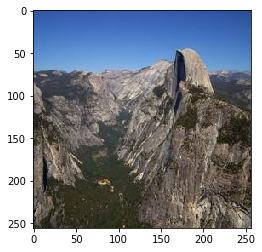

In [7]:
img = cv2.imread(image_list[0], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# label dictionary

In [8]:
label_dict = {}
for index, folder in enumerate(folder_list):
    label = folder.split("/")[-1]
    label_dict[label] = index

In [9]:
label_dict

{'산': 0,
 '농구장': 1,
 '시장': 2,
 '수영장': 3,
 '미용실': 4,
 '수상레포츠': 5,
 '놀이공원': 6,
 '야구장': 7,
 '미술관': 8,
 '클럽': 9,
 '호텔': 10,
 '식물원': 11,
 '키즈카페': 12,
 '박물관': 13,
 '동물원': 14,
 '숲': 15,
 '아이스링크': 16,
 '지하철역': 17,
 '폭포': 18,
 '놀이터': 19,
 '아쿠아리움': 20,
 '절': 21,
 '다리': 22,
 'PC방': 23,
 '쇼핑몰': 24,
 '컨벤션센터': 25,
 '공원': 26,
 '공항': 27,
 '교회': 28,
 '궁궐': 29,
 '도서관': 30,
 '축구장': 31,
 '성당': 32,
 '캠핑장': 33,
 '볼링장': 34,
 '베이커리': 35,
 '공연장': 36,
 '해수욕장': 37}

In [10]:
save_dir = os.path.join(work_dir, "data")
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [11]:
with open(os.path.join(save_dir, f"place_{n_class}_label.json"), "w") as json_file:
    json.dump(label_dict, json_file)

# make tfrecord

In [12]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [13]:
tfr_path = os.path.join(save_dir, f"place_{n_class}_{n_image}.tfr")

In [14]:
writer = tf.io.TFRecordWriter(tfr_path)
n = 0

for img in tqdm(image_list):
    try:
        image = cv2.imread(img, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # tf record byte로 되어 있음
        image_to_byte = image.tobytes()

        label = img.split("/")[-3]
        label_encoding = label_dict[label]

        example = tf.train.Example(features=tf.train.Features(feature={
            "image" : _bytes_feature(image_to_byte),
            "label" : _int64_feature(label_encoding)
        }))

        writer.write(example.SerializeToString())
        n += 1
    except:
        print("Invalid image:", img)
        continue
        
writer.close()
print(f"{n} data, TFRecord saved!")

Invalid image: /home/ssac21/UDIGO/train_data/수영장/crawling/img03_01_02_04.gif
Invalid image: /home/ssac21/UDIGO/train_data/수영장/crawling/img01_swimming.gif
Invalid image: /home/ssac21/UDIGO/train_data/수영장/crawling/pic_01_01.gif
Invalid image: /home/ssac21/UDIGO/train_data/수영장/crawling/img04_01_01_01.gif
Invalid image: /home/ssac21/UDIGO/train_data/수상레포츠/crawling/banana_boat179
Invalid image: /home/ssac21/UDIGO/train_data/수상레포츠/crawling/one-footed_skiing064.gif?type=w580
Invalid image: /home/ssac21/UDIGO/train_data/수상레포츠/crawling/yacht449.gif
Invalid image: /home/ssac21/UDIGO/train_data/수상레포츠/crawling/surf_board01.gif?type=w2
Invalid image: /home/ssac21/UDIGO/train_data/수상레포츠/crawling/water_skiing145.gif?type=w966
Invalid image: /home/ssac21/UDIGO/train_data/수상레포츠/crawling/barefoot_ski137.gif
Invalid image: /home/ssac21/UDIGO/train_data/수상레포츠/crawling/one-footed_skiing063.gif?type=w580
Invalid image: /home/ssac21/UDIGO/train_data/수상레포츠/crawling/surfing_board454.gif
Invalid image: /home/ss

In [15]:
os.rename(save_dir+f"/place_{n_class}_{n_image}.tfr", save_dir+f"/place_{n_class}_{n}.tfr")

# decode check

In [20]:
tfr_path = os.path.join(save_dir, f"place_{n_class}_{n}.tfr")
dataset = tf.data.TFRecordDataset(tfr_path)

In [21]:
features = {'image': tf.io.FixedLenFeature([], tf.string),
            'label': tf.io.FixedLenFeature([], tf.int64)
           }

In [22]:
def _parse_image(example):
    return tf.io.parse_single_example(example, features)

parsed_dataset = dataset.map(_parse_image)

tf.Tensor(0, shape=(), dtype=int64)


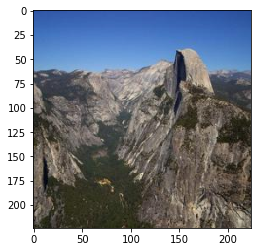

tf.Tensor(0, shape=(), dtype=int64)


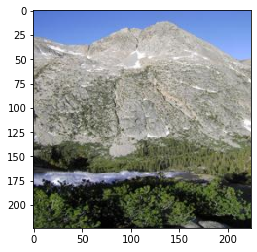

tf.Tensor(0, shape=(), dtype=int64)


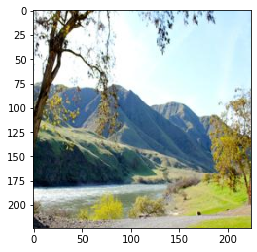

tf.Tensor(0, shape=(), dtype=int64)


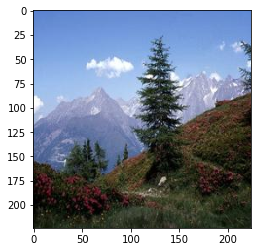

tf.Tensor(0, shape=(), dtype=int64)


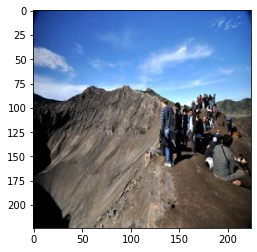

In [23]:
for data in parsed_dataset.take(5):
    print(data['label'])
    image_raw = tf.io.decode_raw(data['image'], tf.uint8)
    image_raw = tf.reshape(image_raw, [224, 224, 3])
    plt.imshow(image_raw)
    plt.show()